In [1]:
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio

In [2]:
CALIBRATION_BASEPATH = 'data/measurment-1/calibrations/'
CALIBRATION_FILE_A = '230320-010-calibration-A-0dB.wav'
CALIBRATION_FILE_B = '230320-011-calibration-B-0dB.wav'

calibration_path_A = os.path.join(CALIBRATION_BASEPATH, CALIBRATION_FILE_A)
calibration_path_B = os.path.join(CALIBRATION_BASEPATH, CALIBRATION_FILE_B)

In [3]:
AUDIO_BASEPATH = 'data/measurment-1/jumps/'
AUDIO_FILE = '230320-009-jump-2.wav'

audio_path = os.path.join(AUDIO_BASEPATH, AUDIO_FILE)

In [4]:
audio, sr = librosa.load(audio_path, sr=None, mono=False)

length = audio.shape[1] / sr

print('Audio length: {:.2f} seconds'.format(length))
print('Sample rate: {} Hz'.format(sr))
print('Hydrophone A')

Audio(audio[0], rate=sr)

Audio length: 20.00 seconds
Sample rate: 48000 Hz
Hydrophone A


In [5]:
audio, sr = librosa.load(audio_path, sr=None, mono=False)

length = audio.shape[1] / sr

print('Audio length: {:.2f} seconds'.format(length))
print('Sample rate: {} Hz'.format(sr))
print('Hydrophone B')

Audio(audio[1], rate=sr)

Audio length: 20.00 seconds
Sample rate: 48000 Hz
Hydrophone B


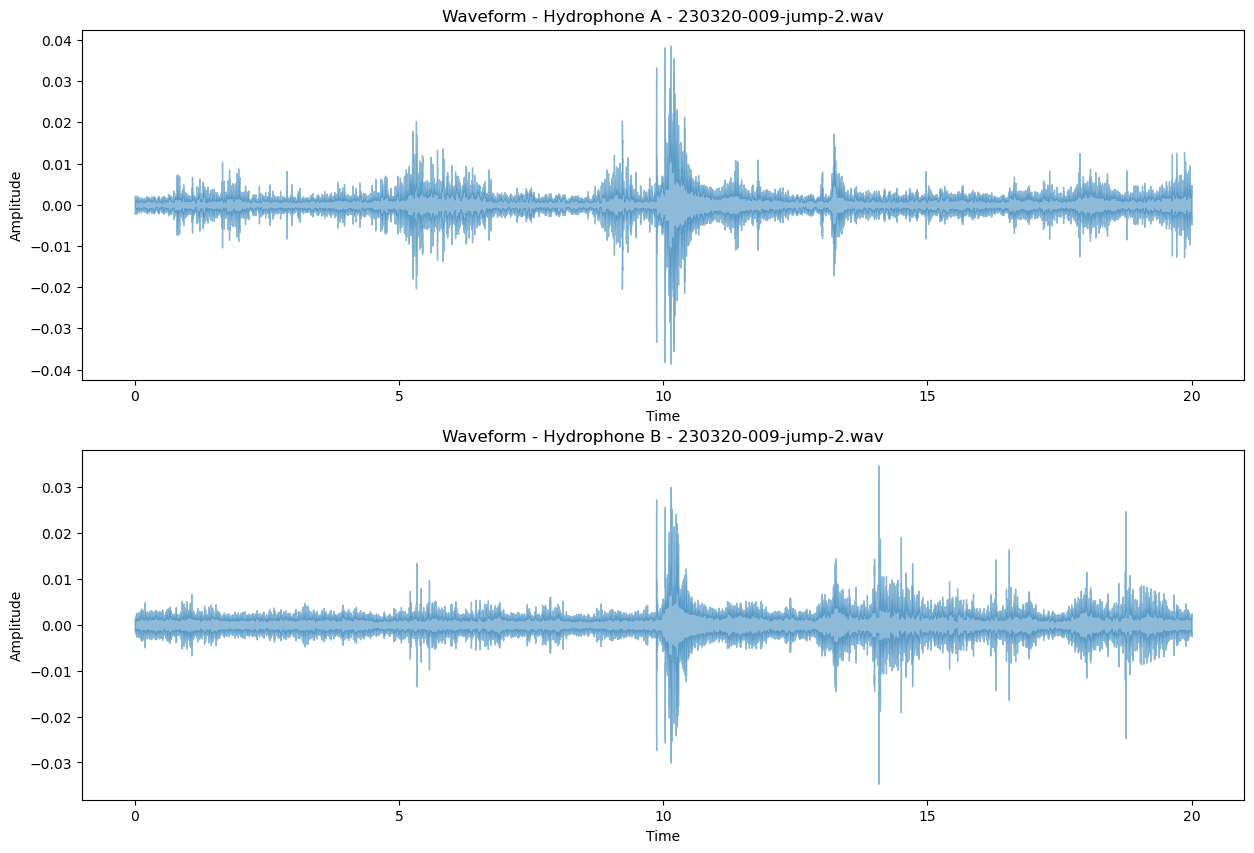

In [6]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
librosa.display.waveshow(audio[0], sr=sr, alpha=0.5)
plt.title(f'Waveform - Hydrophone A - {AUDIO_FILE}')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
librosa.display.waveshow(audio[1], sr=sr, alpha=0.5)
plt.title(f'Waveform - Hydrophone B - {AUDIO_FILE}')
plt.ylabel('Amplitude')

plt.show()

In [7]:
NFFT = 1024
HOP_LENGTH = 512
TOP_DB = 80

spectrogram = librosa.stft(audio, n_fft=NFFT, hop_length=HOP_LENGTH)
spectrogram_db = librosa.amplitude_to_db(np.abs(spectrogram), top_db=TOP_DB, ref=np.max) # TODO: ref=np.max is propebly not correct

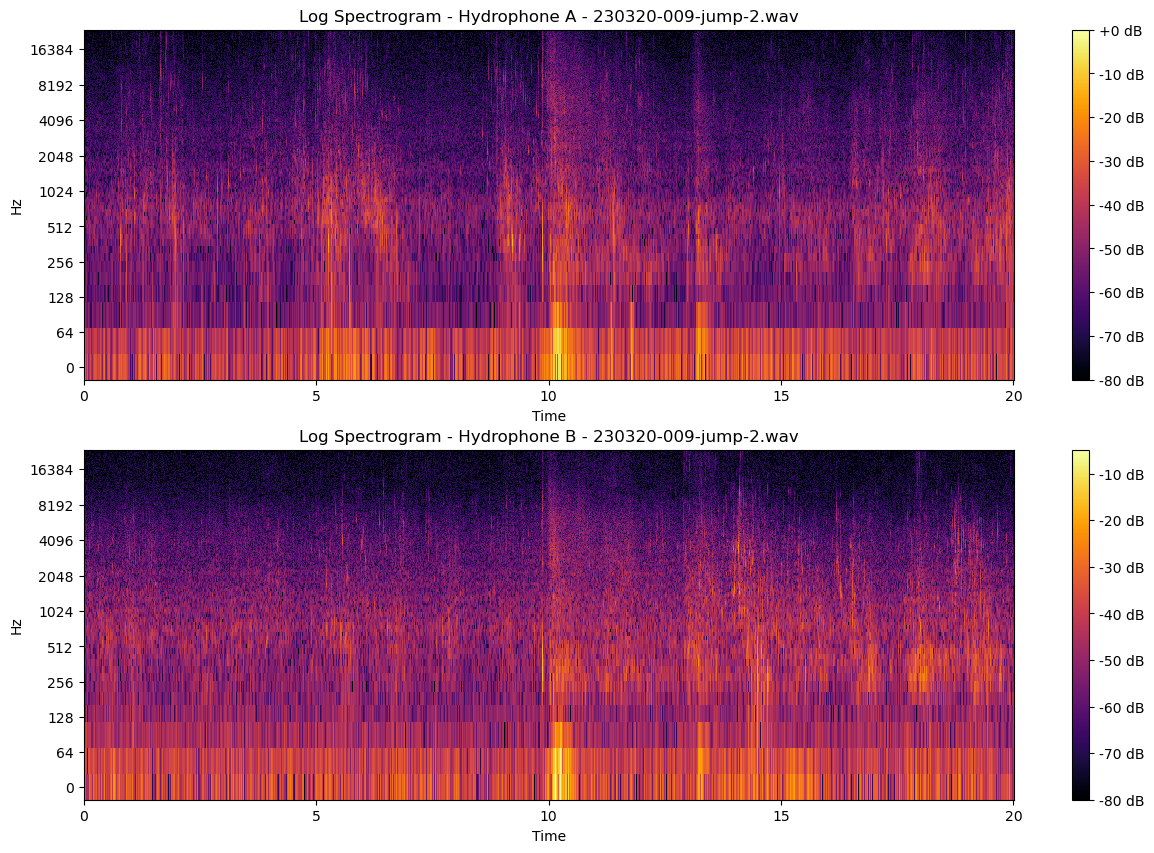

In [8]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
im = librosa.display.specshow(spectrogram_db[0], sr=sr, hop_length=HOP_LENGTH, x_axis='time', y_axis='log', cmap='inferno')
plt.colorbar(im, format='%+2.0f dB')
plt.title(f'Log Spectrogram - Hydrophone A - {AUDIO_FILE}')

plt.subplot(2, 1, 2)
im = librosa.display.specshow(spectrogram_db[1], sr=sr, hop_length=HOP_LENGTH, x_axis='time', y_axis='log', cmap='inferno')
plt.colorbar(im, format='%+2.0f dB')
plt.title(f'Log Spectrogram - Hydrophone B - {AUDIO_FILE}')

plt.show()

In [9]:
REF_EFF = 20e-5 # Pa
CAL_SPL = 128 # dB

def calculate_calibration_gain(calibration_path, ref_eff=REF_EFF, cal_spl=CAL_SPL):
    print(f'Calibration file: {calibration_path}')
    
    calibration, sr = librosa.load(calibration_path, sr=None, mono=True)
    length = calibration.shape[0] / sr
    print(f'Calibration length: {length:.2f} seconds')
    
    calibration_rms = np.sqrt(np.mean(calibration**2))
    calibration_spl = 20 * np.log10(calibration_rms / ref_eff)
    print(f'Calibration SPL: {calibration_spl:.2f} dB')

    gain_db = calibration_spl - cal_spl
    calibration_gain = 10**(gain_db / 20)
    print(f'Calibration gain: {gain_db:.2f} dB ({calibration_gain})', end='\n\n')
    
    return calibration_gain

calibration_gain_A = calculate_calibration_gain(calibration_path_A)
calibration_gain_B = calculate_calibration_gain(calibration_path_B)

Calibration file: data/measurment-1/calibrations/230320-010-calibration-A-0dB.wav
Calibration length: 13.00 seconds
Calibration SPL: 33.92 dB
Calibration gain: -94.08 dB (1.975970258302893e-05)

Calibration file: data/measurment-1/calibrations/230320-011-calibration-B-0dB.wav
Calibration length: 14.00 seconds
Calibration SPL: 34.26 dB
Calibration gain: -93.74 dB (2.0562739523400796e-05)



In [10]:
FRAME_SIZE = int(48000 * 0.125) # 125 ms (fast RMS)
HOP_LENGTH = FRAME_SIZE // 2

audio_rms = librosa.feature.rms(y=audio, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)

audio_spl_A = librosa.amplitude_to_db(audio_rms[0], ref=calibration_gain_A).reshape(-1)
audio_spl_B = librosa.amplitude_to_db(audio_rms[1], ref=calibration_gain_B).reshape(-1)

time = librosa.times_like(audio_spl_A, sr=sr, hop_length=HOP_LENGTH)

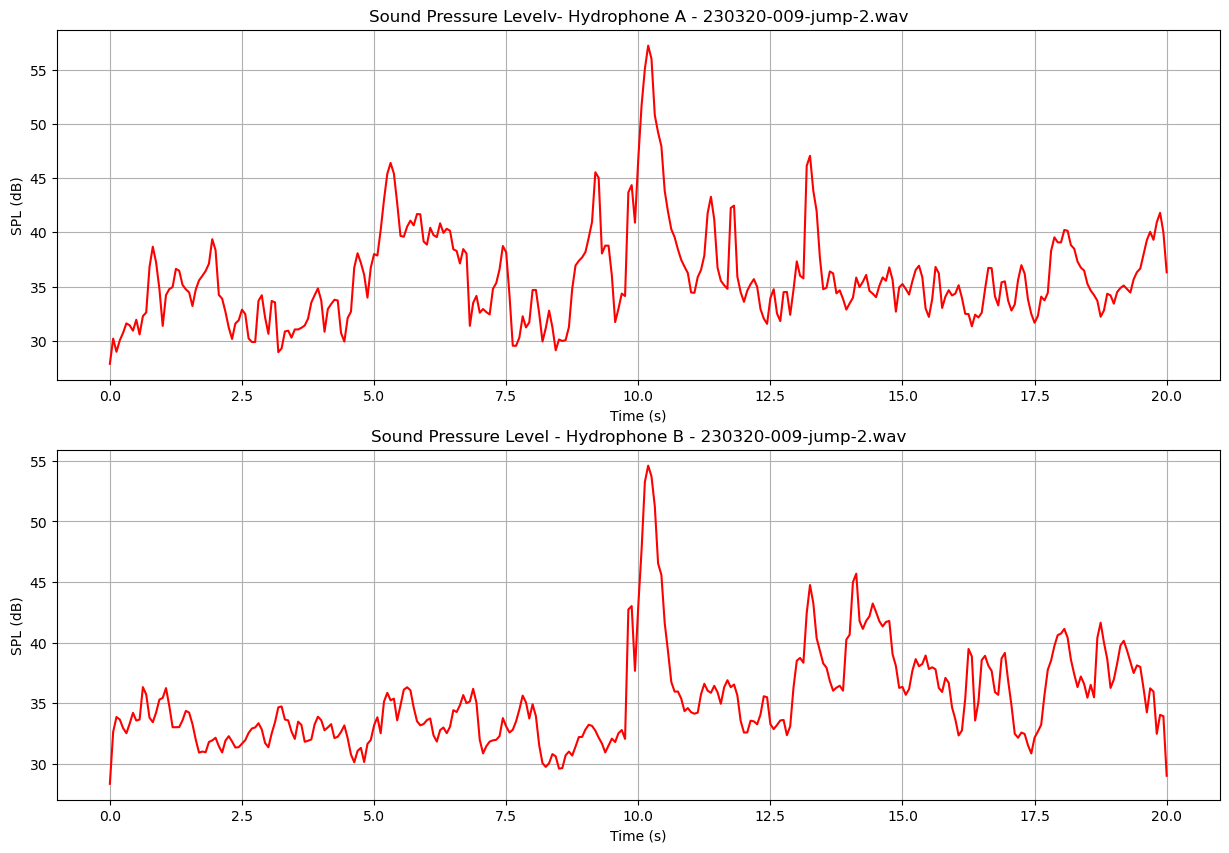

In [11]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(time, audio_spl_A, color='red')
plt.title(f'Sound Pressure Levelv- Hydrophone A - {AUDIO_FILE}')
plt.xlabel('Time (s)')
plt.ylabel('SPL (dB)')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(time, audio_spl_B, color='red')
plt.title(f'Sound Pressure Level - Hydrophone B - {AUDIO_FILE}')
plt.xlabel('Time (s)')
plt.ylabel('SPL (dB)')
plt.grid()

plt.show()